# Fruit Classifer

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


##  Loading our images 

In [2]:
train_data_dir = './fruits-360/train'
validation_data_dir = './fruits-360/validation'

In [3]:
num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 16

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


# Building Model

In [17]:
model = Sequential()

In [18]:
# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [19]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("./fruits_fresh_cnn.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 15

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/15
2582/2582 [==============================] - 706s 273ms/step - loss: 1.8861 - accuracy: 0.4449 - val_loss: 7.9423e-06 - val_accuracy: 0.8501

Epoch 00001: val_loss improved from inf to 0.00001, saving model to ./fruits_fresh_cnn.h5
Epoch 2/15
2582/2582 [==============================] - 300s 116ms/step - loss: 0.6671 - accuracy: 0.7883 - val_loss: 0.0143 - val_accuracy: 0.7993

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/15
2582/2582 [==============================] - 265s 103ms/step - loss: 0.5006 - accuracy: 0.8507 - val_loss: 6.3937e-05 - val_accuracy: 0.9525

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/15
2582/2582 [==============================] - 271s 105ms/step - loss: 0.4978 - accuracy: 0.8637 - val_loss: 0.0000e+00 - val_accuracy: 0.9386

Epoch 00004: val_loss improved from 0.00001 to 0.00000, saving model to ./fruits_fresh_cnn.h5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/15
2582/2582 [==

# Displaying Confusion Matrix

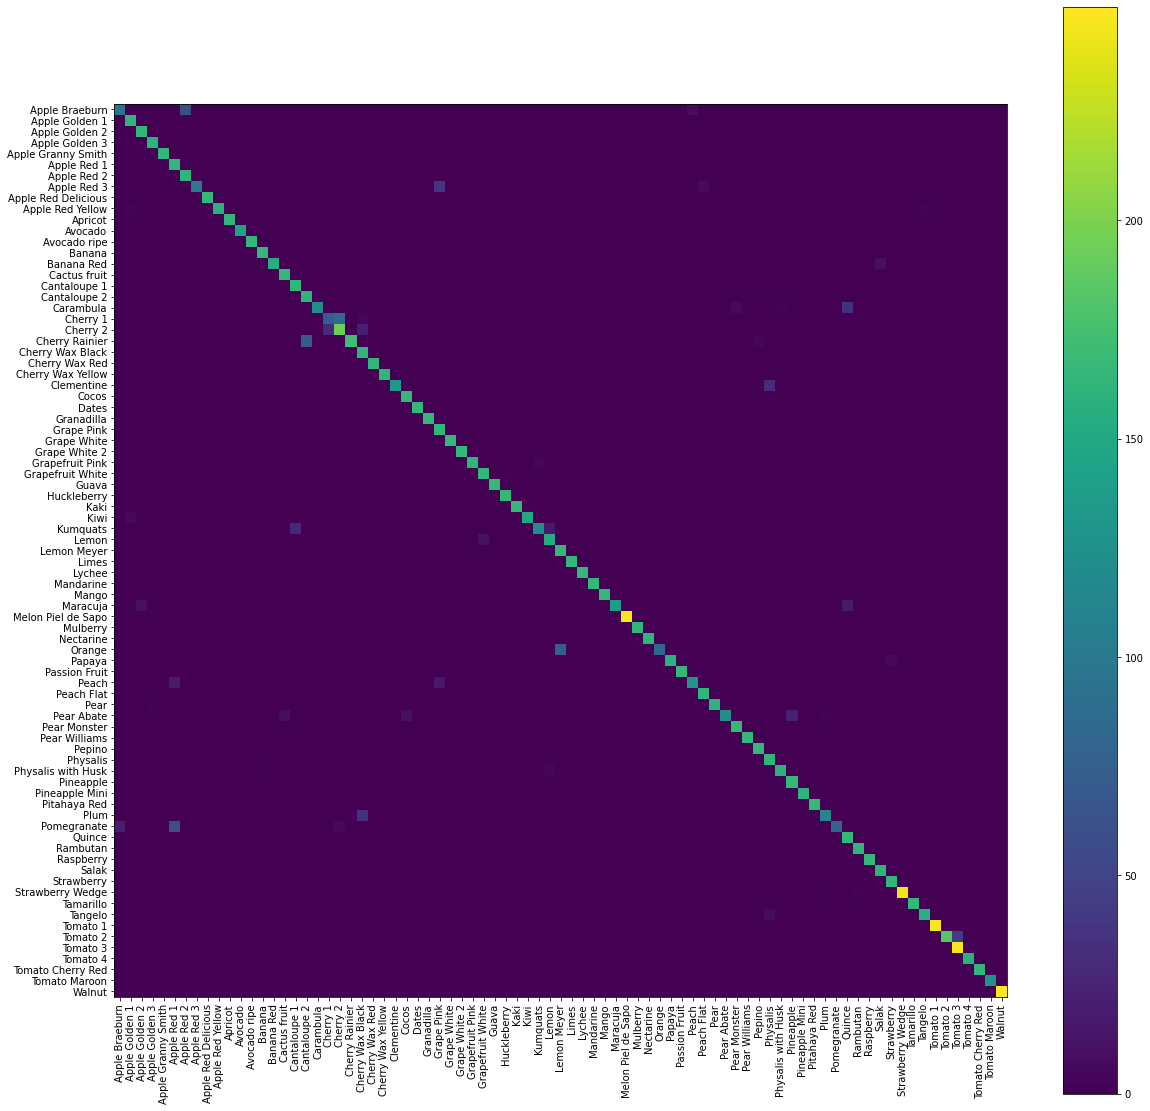

In [5]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('./fruits_fresh_cnn.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 41322
nb_validation_samples = 13877

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 96   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 164 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 127   0]
 [  0   0   0 ...   0   0 249]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.82      0.59      0.68       164
     Apple Golden 1       0.95      1.00      0.98       164
     Apple Golden 2       0.94      1.00      0.97       164
     Apple Golden 3       0.99      1.00      0.99       161
 Apple Granny Smith       1.00      1.00      1.00       164
        Apple Red 1       0.67      1.00      0.81       164
        Apple Red 2       0.73      1.00      0.85       164
        Apple Red 3       1.00      0.69      0.81       144
Apple Red Delicious       1.00      1.00      1.00       166
   Apple Red Yellow       1.00      0.98      0.99       164
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      

# Testing Model

In [8]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './fruits-360/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()